In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.autograd import Variable


bs = 32
transform = transforms.Compose([
                transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc21 = nn.Linear(512, 512)
        self.fc22 = nn.Linear(512, 512)

        # Decoder
        self.fc3 = nn.Linear(512, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        return self.fc21(fc1), self.fc22(fc1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
vae = VAE()
params = list(vae.parameters())
if torch.cuda.is_available():
    vae.cuda()


In [4]:
# build model
vae

VAE(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=512, out_features=512, bias=True)
  (fc22): Linear(in_features=512, out_features=512, bias=True)
  

In [5]:
optimizer = optim.Adam(
        vae.parameters(), lr=1e-03,
        
        
    )
# return reconstruction error + KL divergence losses
def loss_function(x_reconstructed, x, mu, log_var):
    mse_loss = nn.MSELoss(reduction='sum')
    MSE = mse_loss(x_reconstructed, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

In [6]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [9]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(1, 21):
    train(epoch)
    test()
    
end.record()
torch.cuda.synchronize()

print(start.elapsed_time(end))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2449.638184
Train Epoch: 1 [400/50000 (1%)]	Loss: 2244.563721
Train Epoch: 1 [800/50000 (2%)]	Loss: 5208.319336
Train Epoch: 1 [1200/50000 (2%)]	Loss: 2946.080078
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2295.802002
Train Epoch: 1 [2000/50000 (4%)]	Loss: 2700.864746
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2592.147705
Train Epoch: 1 [2800/50000 (6%)]	Loss: 3091.136719
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2267.728516
Train Epoch: 1 [3600/50000 (7%)]	Loss: 3363.950195
Train Epoch: 1 [4000/50000 (8%)]	Loss: 2325.743164
Train Epoch: 1 [4400/50000 (9%)]	Loss: 2783.603027
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2779.901611
Train Epoch: 1 [5200/50000 (10%)]	Loss: 4393.828613
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2633.215332
Train Epoch: 1 [6000/50000 (12%)]	Loss: 2738.400146
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2091.231689
Train Epoch: 1 [6800/50000 (14%)]	Loss: 3495.166504
Train Epoch: 1 [7200/50000 (14%)]	Loss: 1920.259277
Train Epoch: 1 [7600/50000 (1

Train Epoch: 2 [12000/50000 (24%)]	Loss: 2951.664795
Train Epoch: 2 [12400/50000 (25%)]	Loss: 2646.900146
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1695.968994
Train Epoch: 2 [13200/50000 (26%)]	Loss: 1661.187134
Train Epoch: 2 [13600/50000 (27%)]	Loss: 2689.668457
Train Epoch: 2 [14000/50000 (28%)]	Loss: 2699.205078
Train Epoch: 2 [14400/50000 (29%)]	Loss: 3408.968018
Train Epoch: 2 [14800/50000 (30%)]	Loss: 2542.099365
Train Epoch: 2 [15200/50000 (30%)]	Loss: 2462.258545
Train Epoch: 2 [15600/50000 (31%)]	Loss: 3399.973145
Train Epoch: 2 [16000/50000 (32%)]	Loss: 3030.956543
Train Epoch: 2 [16400/50000 (33%)]	Loss: 2389.553711
Train Epoch: 2 [16800/50000 (34%)]	Loss: 2877.747803
Train Epoch: 2 [17200/50000 (34%)]	Loss: 3777.974609
Train Epoch: 2 [17600/50000 (35%)]	Loss: 1702.807129
Train Epoch: 2 [18000/50000 (36%)]	Loss: 1871.526001
Train Epoch: 2 [18400/50000 (37%)]	Loss: 1441.518799
Train Epoch: 2 [18800/50000 (38%)]	Loss: 2425.783447
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1949.

Train Epoch: 3 [24000/50000 (48%)]	Loss: 1836.323975
Train Epoch: 3 [24400/50000 (49%)]	Loss: 2776.509521
Train Epoch: 3 [24800/50000 (50%)]	Loss: 2087.872803
Train Epoch: 3 [25200/50000 (50%)]	Loss: 1975.827881
Train Epoch: 3 [25600/50000 (51%)]	Loss: 3097.118408
Train Epoch: 3 [26000/50000 (52%)]	Loss: 2814.346924
Train Epoch: 3 [26400/50000 (53%)]	Loss: 2095.564453
Train Epoch: 3 [26800/50000 (54%)]	Loss: 1525.542358
Train Epoch: 3 [27200/50000 (54%)]	Loss: 1662.207642
Train Epoch: 3 [27600/50000 (55%)]	Loss: 2297.748047
Train Epoch: 3 [28000/50000 (56%)]	Loss: 2034.958008
Train Epoch: 3 [28400/50000 (57%)]	Loss: 2423.760010
Train Epoch: 3 [28800/50000 (58%)]	Loss: 2142.961182
Train Epoch: 3 [29200/50000 (58%)]	Loss: 2180.393555
Train Epoch: 3 [29600/50000 (59%)]	Loss: 2597.129150
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1478.919800
Train Epoch: 3 [30400/50000 (61%)]	Loss: 1656.644409
Train Epoch: 3 [30800/50000 (62%)]	Loss: 1810.668457
Train Epoch: 3 [31200/50000 (62%)]	Loss: 1801.

Train Epoch: 4 [36000/50000 (72%)]	Loss: 2137.684814
Train Epoch: 4 [36400/50000 (73%)]	Loss: 1696.287109
Train Epoch: 4 [36800/50000 (74%)]	Loss: 2822.304932
Train Epoch: 4 [37200/50000 (74%)]	Loss: 2560.833496
Train Epoch: 4 [37600/50000 (75%)]	Loss: 1563.922974
Train Epoch: 4 [38000/50000 (76%)]	Loss: 1741.292480
Train Epoch: 4 [38400/50000 (77%)]	Loss: 2671.077637
Train Epoch: 4 [38800/50000 (78%)]	Loss: 1633.782471
Train Epoch: 4 [39200/50000 (78%)]	Loss: 1557.137329
Train Epoch: 4 [39600/50000 (79%)]	Loss: 1617.824829
Train Epoch: 4 [40000/50000 (80%)]	Loss: 1512.050293
Train Epoch: 4 [40400/50000 (81%)]	Loss: 2228.203613
Train Epoch: 4 [40800/50000 (82%)]	Loss: 2605.042480
Train Epoch: 4 [41200/50000 (82%)]	Loss: 1528.989746
Train Epoch: 4 [41600/50000 (83%)]	Loss: 1640.152100
Train Epoch: 4 [42000/50000 (84%)]	Loss: 2087.780273
Train Epoch: 4 [42400/50000 (85%)]	Loss: 2180.322510
Train Epoch: 4 [42800/50000 (86%)]	Loss: 1838.035889
Train Epoch: 4 [43200/50000 (86%)]	Loss: 1628.

Train Epoch: 5 [48000/50000 (96%)]	Loss: 1892.255981
Train Epoch: 5 [48400/50000 (97%)]	Loss: 1732.780884
Train Epoch: 5 [48800/50000 (98%)]	Loss: 1573.460938
Train Epoch: 5 [49200/50000 (98%)]	Loss: 1769.657715
Train Epoch: 5 [49600/50000 (99%)]	Loss: 1632.717651
====> Epoch: 5 Average loss: 1892.3772
====> Test set loss: 1640.3894
Train Epoch: 6 [0/50000 (0%)]	Loss: 1662.519653
Train Epoch: 6 [400/50000 (1%)]	Loss: 1557.955688
Train Epoch: 6 [800/50000 (2%)]	Loss: 2393.658691
Train Epoch: 6 [1200/50000 (2%)]	Loss: 1410.604980
Train Epoch: 6 [1600/50000 (3%)]	Loss: 1681.027466
Train Epoch: 6 [2000/50000 (4%)]	Loss: 2545.268799
Train Epoch: 6 [2400/50000 (5%)]	Loss: 2750.683594
Train Epoch: 6 [2800/50000 (6%)]	Loss: 1287.033325
Train Epoch: 6 [3200/50000 (6%)]	Loss: 1459.683350
Train Epoch: 6 [3600/50000 (7%)]	Loss: 2459.692627
Train Epoch: 6 [4000/50000 (8%)]	Loss: 1601.461792
Train Epoch: 6 [4400/50000 (9%)]	Loss: 2109.747803
Train Epoch: 6 [4800/50000 (10%)]	Loss: 1727.293091
Train 

Train Epoch: 7 [9600/50000 (19%)]	Loss: 2021.473999
Train Epoch: 7 [10000/50000 (20%)]	Loss: 1777.950806
Train Epoch: 7 [10400/50000 (21%)]	Loss: 1350.806274
Train Epoch: 7 [10800/50000 (22%)]	Loss: 1725.870117
Train Epoch: 7 [11200/50000 (22%)]	Loss: 1384.918335
Train Epoch: 7 [11600/50000 (23%)]	Loss: 1489.819702
Train Epoch: 7 [12000/50000 (24%)]	Loss: 2051.318848
Train Epoch: 7 [12400/50000 (25%)]	Loss: 1120.939697
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1623.813721
Train Epoch: 7 [13200/50000 (26%)]	Loss: 1534.109009
Train Epoch: 7 [13600/50000 (27%)]	Loss: 2046.540771
Train Epoch: 7 [14000/50000 (28%)]	Loss: 1754.440796
Train Epoch: 7 [14400/50000 (29%)]	Loss: 2127.794922
Train Epoch: 7 [14800/50000 (30%)]	Loss: 1287.305786
Train Epoch: 7 [15200/50000 (30%)]	Loss: 2188.432373
Train Epoch: 7 [15600/50000 (31%)]	Loss: 1809.009766
Train Epoch: 7 [16000/50000 (32%)]	Loss: 1738.535156
Train Epoch: 7 [16400/50000 (33%)]	Loss: 1351.502808
Train Epoch: 7 [16800/50000 (34%)]	Loss: 2021.7

Train Epoch: 8 [21600/50000 (43%)]	Loss: 1418.226074
Train Epoch: 8 [22000/50000 (44%)]	Loss: 1765.635010
Train Epoch: 8 [22400/50000 (45%)]	Loss: 1547.128906
Train Epoch: 8 [22800/50000 (46%)]	Loss: 1491.584473
Train Epoch: 8 [23200/50000 (46%)]	Loss: 1244.284058
Train Epoch: 8 [23600/50000 (47%)]	Loss: 1373.868530
Train Epoch: 8 [24000/50000 (48%)]	Loss: 1231.542480
Train Epoch: 8 [24400/50000 (49%)]	Loss: 2327.955322
Train Epoch: 8 [24800/50000 (50%)]	Loss: 1249.934814
Train Epoch: 8 [25200/50000 (50%)]	Loss: 2089.942139
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1586.231323
Train Epoch: 8 [26000/50000 (52%)]	Loss: 1716.310059
Train Epoch: 8 [26400/50000 (53%)]	Loss: 1742.772583
Train Epoch: 8 [26800/50000 (54%)]	Loss: 1585.080811
Train Epoch: 8 [27200/50000 (54%)]	Loss: 2831.336182
Train Epoch: 8 [27600/50000 (55%)]	Loss: 1560.799927
Train Epoch: 8 [28000/50000 (56%)]	Loss: 1398.149170
Train Epoch: 8 [28400/50000 (57%)]	Loss: 1455.470459
Train Epoch: 8 [28800/50000 (58%)]	Loss: 1471.

Train Epoch: 9 [33600/50000 (67%)]	Loss: 1140.373291
Train Epoch: 9 [34000/50000 (68%)]	Loss: 1423.109497
Train Epoch: 9 [34400/50000 (69%)]	Loss: 1419.614258
Train Epoch: 9 [34800/50000 (70%)]	Loss: 1429.707397
Train Epoch: 9 [35200/50000 (70%)]	Loss: 1155.930542
Train Epoch: 9 [35600/50000 (71%)]	Loss: 1665.736328
Train Epoch: 9 [36000/50000 (72%)]	Loss: 2012.692017
Train Epoch: 9 [36400/50000 (73%)]	Loss: 2259.920410
Train Epoch: 9 [36800/50000 (74%)]	Loss: 1228.410645
Train Epoch: 9 [37200/50000 (74%)]	Loss: 1307.786865
Train Epoch: 9 [37600/50000 (75%)]	Loss: 1557.395630
Train Epoch: 9 [38000/50000 (76%)]	Loss: 1172.982056
Train Epoch: 9 [38400/50000 (77%)]	Loss: 2280.361816
Train Epoch: 9 [38800/50000 (78%)]	Loss: 1656.072388
Train Epoch: 9 [39200/50000 (78%)]	Loss: 1622.994385
Train Epoch: 9 [39600/50000 (79%)]	Loss: 1334.341187
Train Epoch: 9 [40000/50000 (80%)]	Loss: 1483.774292
Train Epoch: 9 [40400/50000 (81%)]	Loss: 1352.068115
Train Epoch: 9 [40800/50000 (82%)]	Loss: 1822.

Train Epoch: 10 [44400/50000 (89%)]	Loss: 1301.956177
Train Epoch: 10 [44800/50000 (90%)]	Loss: 1400.924561
Train Epoch: 10 [45200/50000 (90%)]	Loss: 2202.241455
Train Epoch: 10 [45600/50000 (91%)]	Loss: 1970.794556
Train Epoch: 10 [46000/50000 (92%)]	Loss: 2047.346680
Train Epoch: 10 [46400/50000 (93%)]	Loss: 1279.939941
Train Epoch: 10 [46800/50000 (94%)]	Loss: 1110.155762
Train Epoch: 10 [47200/50000 (94%)]	Loss: 1711.358032
Train Epoch: 10 [47600/50000 (95%)]	Loss: 2694.646484
Train Epoch: 10 [48000/50000 (96%)]	Loss: 1094.339600
Train Epoch: 10 [48400/50000 (97%)]	Loss: 1316.911011
Train Epoch: 10 [48800/50000 (98%)]	Loss: 1844.325562
Train Epoch: 10 [49200/50000 (98%)]	Loss: 2094.439453
Train Epoch: 10 [49600/50000 (99%)]	Loss: 1787.362671
====> Epoch: 10 Average loss: 1692.6298
====> Test set loss: 1526.9287
Train Epoch: 11 [0/50000 (0%)]	Loss: 1785.794678
Train Epoch: 11 [400/50000 (1%)]	Loss: 1517.076904
Train Epoch: 11 [800/50000 (2%)]	Loss: 1343.325439
Train Epoch: 11 [1200/

Train Epoch: 12 [4800/50000 (10%)]	Loss: 2519.996582
Train Epoch: 12 [5200/50000 (10%)]	Loss: 1196.637329
Train Epoch: 12 [5600/50000 (11%)]	Loss: 2624.529785
Train Epoch: 12 [6000/50000 (12%)]	Loss: 1446.202759
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1373.670654
Train Epoch: 12 [6800/50000 (14%)]	Loss: 1325.333984
Train Epoch: 12 [7200/50000 (14%)]	Loss: 1689.185303
Train Epoch: 12 [7600/50000 (15%)]	Loss: 1576.344238
Train Epoch: 12 [8000/50000 (16%)]	Loss: 2179.587646
Train Epoch: 12 [8400/50000 (17%)]	Loss: 1091.183350
Train Epoch: 12 [8800/50000 (18%)]	Loss: 1489.026245
Train Epoch: 12 [9200/50000 (18%)]	Loss: 1587.016235
Train Epoch: 12 [9600/50000 (19%)]	Loss: 1531.116821
Train Epoch: 12 [10000/50000 (20%)]	Loss: 1409.087280
Train Epoch: 12 [10400/50000 (21%)]	Loss: 1711.265869
Train Epoch: 12 [10800/50000 (22%)]	Loss: 2123.973877
Train Epoch: 12 [11200/50000 (22%)]	Loss: 1569.227295
Train Epoch: 12 [11600/50000 (23%)]	Loss: 1760.725098
Train Epoch: 12 [12000/50000 (24%)]	Loss:

Train Epoch: 13 [15600/50000 (31%)]	Loss: 1234.910034
Train Epoch: 13 [16000/50000 (32%)]	Loss: 1606.458740
Train Epoch: 13 [16400/50000 (33%)]	Loss: 1067.403687
Train Epoch: 13 [16800/50000 (34%)]	Loss: 1935.111328
Train Epoch: 13 [17200/50000 (34%)]	Loss: 2521.121094
Train Epoch: 13 [17600/50000 (35%)]	Loss: 2007.883667
Train Epoch: 13 [18000/50000 (36%)]	Loss: 1338.298828
Train Epoch: 13 [18400/50000 (37%)]	Loss: 1008.279968
Train Epoch: 13 [18800/50000 (38%)]	Loss: 1219.486328
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1909.106079
Train Epoch: 13 [19600/50000 (39%)]	Loss: 1943.989990
Train Epoch: 13 [20000/50000 (40%)]	Loss: 1695.219238
Train Epoch: 13 [20400/50000 (41%)]	Loss: 1731.270142
Train Epoch: 13 [20800/50000 (42%)]	Loss: 1444.783936
Train Epoch: 13 [21200/50000 (42%)]	Loss: 1599.712524
Train Epoch: 13 [21600/50000 (43%)]	Loss: 1377.528320
Train Epoch: 13 [22000/50000 (44%)]	Loss: 1276.102417
Train Epoch: 13 [22400/50000 (45%)]	Loss: 1528.014038
Train Epoch: 13 [22800/50000

Train Epoch: 14 [26400/50000 (53%)]	Loss: 1614.684448
Train Epoch: 14 [26800/50000 (54%)]	Loss: 1344.331787
Train Epoch: 14 [27200/50000 (54%)]	Loss: 1386.868896
Train Epoch: 14 [27600/50000 (55%)]	Loss: 1182.125244
Train Epoch: 14 [28000/50000 (56%)]	Loss: 1626.311646
Train Epoch: 14 [28400/50000 (57%)]	Loss: 1672.820679
Train Epoch: 14 [28800/50000 (58%)]	Loss: 1558.485718
Train Epoch: 14 [29200/50000 (58%)]	Loss: 1667.715088
Train Epoch: 14 [29600/50000 (59%)]	Loss: 1552.559204
Train Epoch: 14 [30000/50000 (60%)]	Loss: 1244.696533
Train Epoch: 14 [30400/50000 (61%)]	Loss: 2125.843994
Train Epoch: 14 [30800/50000 (62%)]	Loss: 1972.333130
Train Epoch: 14 [31200/50000 (62%)]	Loss: 1863.009033
Train Epoch: 14 [31600/50000 (63%)]	Loss: 1435.526855
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1769.923584
Train Epoch: 14 [32400/50000 (65%)]	Loss: 1664.905151
Train Epoch: 14 [32800/50000 (66%)]	Loss: 1242.207520
Train Epoch: 14 [33200/50000 (66%)]	Loss: 1619.856689
Train Epoch: 14 [33600/50000

Train Epoch: 15 [37200/50000 (74%)]	Loss: 1864.161499
Train Epoch: 15 [37600/50000 (75%)]	Loss: 1624.141724
Train Epoch: 15 [38000/50000 (76%)]	Loss: 1531.954346
Train Epoch: 15 [38400/50000 (77%)]	Loss: 1830.876587
Train Epoch: 15 [38800/50000 (78%)]	Loss: 1572.934082
Train Epoch: 15 [39200/50000 (78%)]	Loss: 1196.553833
Train Epoch: 15 [39600/50000 (79%)]	Loss: 1766.830444
Train Epoch: 15 [40000/50000 (80%)]	Loss: 1671.628418
Train Epoch: 15 [40400/50000 (81%)]	Loss: 1719.585815
Train Epoch: 15 [40800/50000 (82%)]	Loss: 1794.330322
Train Epoch: 15 [41200/50000 (82%)]	Loss: 1714.766724
Train Epoch: 15 [41600/50000 (83%)]	Loss: 1320.310791
Train Epoch: 15 [42000/50000 (84%)]	Loss: 1624.025879
Train Epoch: 15 [42400/50000 (85%)]	Loss: 1843.012573
Train Epoch: 15 [42800/50000 (86%)]	Loss: 1269.077881
Train Epoch: 15 [43200/50000 (86%)]	Loss: 1437.313965
Train Epoch: 15 [43600/50000 (87%)]	Loss: 1899.327515
Train Epoch: 15 [44000/50000 (88%)]	Loss: 1292.460693
Train Epoch: 15 [44400/50000

Train Epoch: 16 [48000/50000 (96%)]	Loss: 1602.954956
Train Epoch: 16 [48400/50000 (97%)]	Loss: 1586.792236
Train Epoch: 16 [48800/50000 (98%)]	Loss: 1593.814941
Train Epoch: 16 [49200/50000 (98%)]	Loss: 1677.847168
Train Epoch: 16 [49600/50000 (99%)]	Loss: 1496.844238
====> Epoch: 16 Average loss: 1593.6827
====> Test set loss: 1375.9323
Train Epoch: 17 [0/50000 (0%)]	Loss: 1658.705200
Train Epoch: 17 [400/50000 (1%)]	Loss: 1401.980225
Train Epoch: 17 [800/50000 (2%)]	Loss: 1879.590210
Train Epoch: 17 [1200/50000 (2%)]	Loss: 2118.125732
Train Epoch: 17 [1600/50000 (3%)]	Loss: 1592.439331
Train Epoch: 17 [2000/50000 (4%)]	Loss: 1811.318115
Train Epoch: 17 [2400/50000 (5%)]	Loss: 1610.842407
Train Epoch: 17 [2800/50000 (6%)]	Loss: 1203.802246
Train Epoch: 17 [3200/50000 (6%)]	Loss: 1158.361328
Train Epoch: 17 [3600/50000 (7%)]	Loss: 1313.003052
Train Epoch: 17 [4000/50000 (8%)]	Loss: 1626.960693
Train Epoch: 17 [4400/50000 (9%)]	Loss: 1790.864624
Train Epoch: 17 [4800/50000 (10%)]	Loss:

Train Epoch: 18 [8400/50000 (17%)]	Loss: 1584.475708
Train Epoch: 18 [8800/50000 (18%)]	Loss: 1556.011475
Train Epoch: 18 [9200/50000 (18%)]	Loss: 1675.240356
Train Epoch: 18 [9600/50000 (19%)]	Loss: 1240.661377
Train Epoch: 18 [10000/50000 (20%)]	Loss: 1344.186768
Train Epoch: 18 [10400/50000 (21%)]	Loss: 1295.092896
Train Epoch: 18 [10800/50000 (22%)]	Loss: 1367.590820
Train Epoch: 18 [11200/50000 (22%)]	Loss: 1795.133057
Train Epoch: 18 [11600/50000 (23%)]	Loss: 1058.779053
Train Epoch: 18 [12000/50000 (24%)]	Loss: 1494.005005
Train Epoch: 18 [12400/50000 (25%)]	Loss: 1638.630005
Train Epoch: 18 [12800/50000 (26%)]	Loss: 1429.817627
Train Epoch: 18 [13200/50000 (26%)]	Loss: 1578.535889
Train Epoch: 18 [13600/50000 (27%)]	Loss: 1893.775635
Train Epoch: 18 [14000/50000 (28%)]	Loss: 1783.462402
Train Epoch: 18 [14400/50000 (29%)]	Loss: 2043.901123
Train Epoch: 18 [14800/50000 (30%)]	Loss: 1486.873779
Train Epoch: 18 [15200/50000 (30%)]	Loss: 1704.762939
Train Epoch: 18 [15600/50000 (31

Train Epoch: 19 [19200/50000 (38%)]	Loss: 1572.016357
Train Epoch: 19 [19600/50000 (39%)]	Loss: 1772.514893
Train Epoch: 19 [20000/50000 (40%)]	Loss: 1294.751099
Train Epoch: 19 [20400/50000 (41%)]	Loss: 1712.672241
Train Epoch: 19 [20800/50000 (42%)]	Loss: 1073.739136
Train Epoch: 19 [21200/50000 (42%)]	Loss: 1654.216797
Train Epoch: 19 [21600/50000 (43%)]	Loss: 2079.605225
Train Epoch: 19 [22000/50000 (44%)]	Loss: 1958.825073
Train Epoch: 19 [22400/50000 (45%)]	Loss: 1560.049683
Train Epoch: 19 [22800/50000 (46%)]	Loss: 1146.563721
Train Epoch: 19 [23200/50000 (46%)]	Loss: 1289.648560
Train Epoch: 19 [23600/50000 (47%)]	Loss: 2680.824463
Train Epoch: 19 [24000/50000 (48%)]	Loss: 1823.999878
Train Epoch: 19 [24400/50000 (49%)]	Loss: 1782.595215
Train Epoch: 19 [24800/50000 (50%)]	Loss: 1627.960815
Train Epoch: 19 [25200/50000 (50%)]	Loss: 1577.628540
Train Epoch: 19 [25600/50000 (51%)]	Loss: 1007.811157
Train Epoch: 19 [26000/50000 (52%)]	Loss: 1807.417847
Train Epoch: 19 [26400/50000

Train Epoch: 20 [30000/50000 (60%)]	Loss: 1962.697388
Train Epoch: 20 [30400/50000 (61%)]	Loss: 1983.741943
Train Epoch: 20 [30800/50000 (62%)]	Loss: 1311.364746
Train Epoch: 20 [31200/50000 (62%)]	Loss: 1789.598145
Train Epoch: 20 [31600/50000 (63%)]	Loss: 1478.275269
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1452.155518
Train Epoch: 20 [32400/50000 (65%)]	Loss: 2045.063965
Train Epoch: 20 [32800/50000 (66%)]	Loss: 1525.360840
Train Epoch: 20 [33200/50000 (66%)]	Loss: 1295.090698
Train Epoch: 20 [33600/50000 (67%)]	Loss: 1390.134888
Train Epoch: 20 [34000/50000 (68%)]	Loss: 1456.586548
Train Epoch: 20 [34400/50000 (69%)]	Loss: 1163.916382
Train Epoch: 20 [34800/50000 (70%)]	Loss: 1484.080933
Train Epoch: 20 [35200/50000 (70%)]	Loss: 1533.524536
Train Epoch: 20 [35600/50000 (71%)]	Loss: 1271.536865
Train Epoch: 20 [36000/50000 (72%)]	Loss: 1300.019287
Train Epoch: 20 [36400/50000 (73%)]	Loss: 1559.573364
Train Epoch: 20 [36800/50000 (74%)]	Loss: 2317.014404
Train Epoch: 20 [37200/50000

In [11]:
with torch.no_grad():
    z = torch.randn(4, 512).cuda()
    
    sample = vae.decode(z).cpu()
    
    #plt.imshow(sample.view(3,32,32))
    save_image(sample.view(4, 3, 32, 32), './sample_5' +'.png')
    

In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


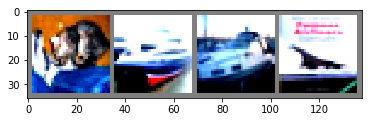

GroundTruth:    cat  ship  ship plane


In [27]:
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
images = images.cuda()

h = vae.encode(images)

z_1 = vae.reparameterize(h[0],h[1])


In [22]:
#vae.decode(z_1).cpu()
z_1.size()

sample_1 = vae.decode(z_1).cpu()
sample_1.size()

torch.Size([4, 3, 32, 32])

In [23]:
sample_1 = sample_1.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


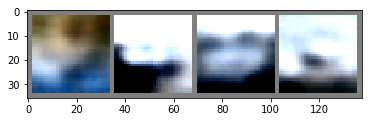

In [24]:
imshow(torchvision.utils.make_grid(sample_1))

In [25]:
labels

tensor([3, 8, 8, 0])

In [28]:
test_loader

In [34]:
for i,data in enumerate(test_loader,0):
    inputs = data[0]
    labels = data[1]
 

In [36]:
inputs

tensor([[[[-2.0995e+00, -1.9832e+00, -1.8863e+00,  ..., -1.5374e+00,
           -1.4792e+00, -1.4598e+00],
          [-2.1771e+00, -2.1383e+00, -2.0995e+00,  ..., -1.2854e+00,
           -1.3047e+00, -1.4017e+00],
          [-1.9832e+00, -2.1189e+00, -2.1577e+00,  ..., -1.2078e+00,
           -1.2660e+00, -1.4017e+00],
          ...,
          [-1.8863e+00, -1.8863e+00, -1.8281e+00,  ...,  1.8162e+00,
            1.8356e+00,  1.9132e+00],
          [-1.3823e+00, -1.3435e+00, -1.2660e+00,  ...,  1.4285e+00,
            1.2541e+00,  1.2541e+00],
          [-1.3823e+00, -1.3435e+00, -1.2272e+00,  ...,  1.7193e+00,
            1.4479e+00,  1.3898e+00]],

         [[-2.3593e+00, -2.3789e+00, -2.3986e+00,  ..., -1.8479e+00,
           -1.7496e+00, -1.8086e+00],
          [-2.3199e+00, -2.3986e+00, -2.4183e+00,  ..., -1.7299e+00,
           -1.6316e+00, -1.6709e+00],
          [-2.1233e+00, -2.3199e+00, -2.3986e+00,  ..., -1.9069e+00,
           -1.7102e+00, -1.6709e+00],
          ...,
     

In [39]:
inputs.size()

torch.Size([8, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


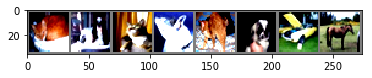

GroundTruth:    cat   dog   cat  ship   cat   dog   car horse


In [45]:
imshow(torchvision.utils.make_grid(inputs.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [46]:
inputs = inputs.cuda()

h_1 = vae.encode(inputs)

z_2 = vae.reparameterize(h_1[0],h_1[1])

z_2.size()

sample_2 = vae.decode(z_2).cpu()
sample_2.size()


torch.Size([8, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


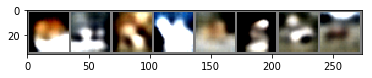

In [47]:
imshow(torchvision.utils.make_grid(sample_2))